## 1. Data Exploration

In [1]:
#Importing the basic librarires

import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [2]:
#Importing the dataset

df = pd.read_csv("./song_data.csv")

df.drop(['song_name'], axis=1, inplace=True)
display(df.head())

target = 'song_popularity'
features = [i for i in df.columns if i not in [target]]

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574



Inference: The Datset consists of 14 features & 18835 samples.


In [3]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.0 MB


In [4]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

audio_mode              2
time_signature          5
key                    12
song_popularity       101
danceability          849
energy               1132
speechiness          1224
audio_valence        1246
liveness             1425
acousticness         3209
instrumentalness     3925
loudness             8416
song_duration_ms    11771
tempo               12112
dtype: int64

In [5]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 10 numerical & 3 categorical features.


In [6]:
#Checking the stats of all the columns

display(df.describe())

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,18835.000000,1.883500e+04,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000
mean,52.991877,2.182116e+05,0.258539,0.633348,0.644995,0.078008,5.289196,0.179650,-7.447435,0.628139,0.102099,121.073154,3.959119,0.527967
std,21.905654,5.988754e+04,0.288719,0.156723,0.214101,0.221591,3.614595,0.143984,3.827831,0.483314,0.104378,28.714456,0.298533,0.244632
min,0.000000,1.200000e+04,0.000001,0.000000,0.001070,0.000000,0.000000,0.010900,-38.768000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,1.843395e+05,0.024100,0.533000,0.510000,0.000000,2.000000,0.092900,-9.044000,0.000000,0.037800,98.368000,4.000000,0.335000
50%,56.000000,2.113060e+05,0.132000,0.645000,0.674000,0.000011,5.000000,0.122000,-6.555000,1.000000,0.055500,120.013000,4.000000,0.527000
75%,69.000000,2.428440e+05,0.424000,0.748000,0.815000,0.002570,8.000000,0.221000,-4.908000,1.000000,0.119000,139.931000,4.000000,0.725000
max,100.000000,1.799346e+06,0.996000,0.987000,0.999000,0.997000,11.000000,0.986000,1.585000,1.000000,0.941000,242.318000,5.000000,0.984000


## 2. Exploratory Data Analysis (EDA)

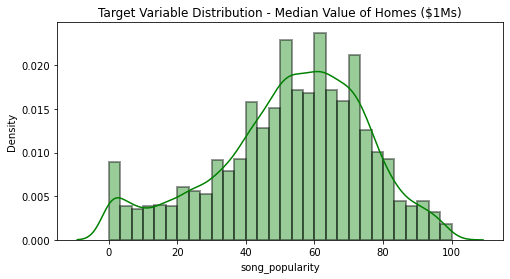

In [7]:
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

                               Visualising Categorical Features:                                


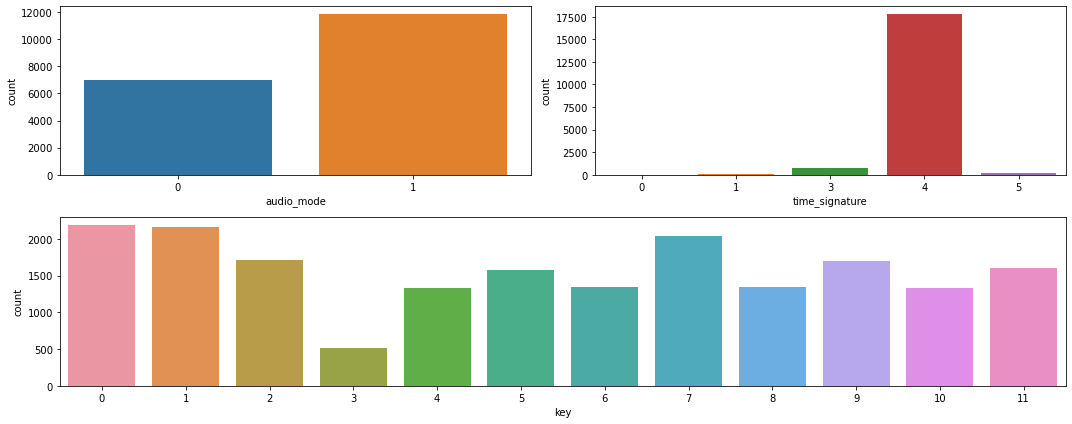

In [8]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=8:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(2,1,2)
        sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

                                 Numeric Features Distribution                                  


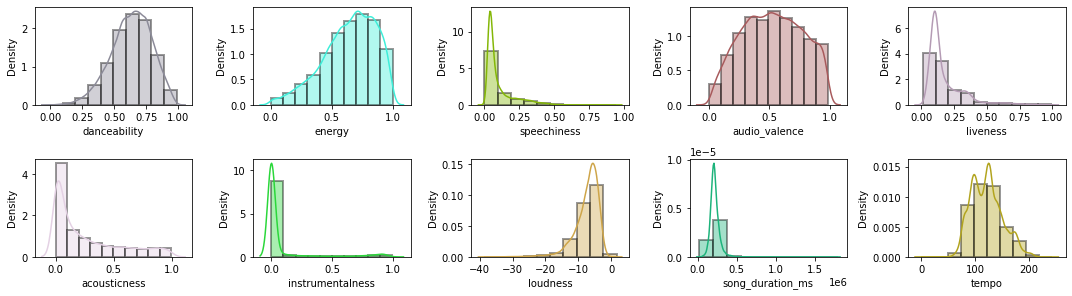

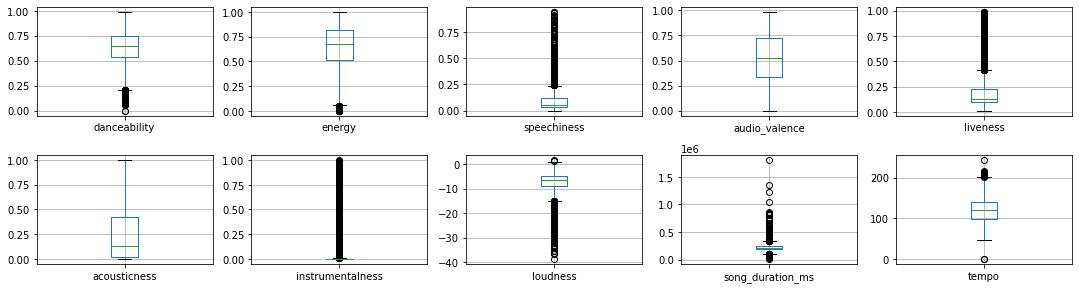

In [12]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(100))

n=5

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

In [ ]:
#Understanding the relationship between all the features

g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

## 3. Data Preprocessing

In [9]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 3911


In [10]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                  Total Null Values  Percentage
song_popularity                   0         0.0
song_duration_ms                  0         0.0
acousticness                      0         0.0
danceability                      0         0.0
energy                            0         0.0
instrumentalness                  0         0.0
key                               0         0.0
liveness                          0         0.0
loudness                          0         0.0
audio_mode                        0         0.0
speechiness                       0         0.0
tempo                             0         0.0
time_signature                    0         0.0
audio_valence                     0         0.0


In [11]:
#Converting categorical Columns to Numeric

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

One-Hot Encoding on features:
audio_mode

Dummy Encoding on features:
time_signature
key


(14924, 27)

In [12]:
#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,73,262333,0.005520,0.496,0.682,0.000029,0.0589,-4.095,1,0.0294,...,0,0,0,0,0,0,1,0,0,0
1,66,216933,0.010300,0.542,0.853,0.000000,0.1080,-6.407,0,0.0498,...,0,1,0,0,0,0,0,0,0,0
2,74,216933,0.026400,0.451,0.970,0.003550,0.1020,-4.938,1,0.1070,...,0,0,0,0,0,0,0,0,0,0
3,56,223826,0.000954,0.447,0.766,0.000000,0.1130,-5.065,1,0.0313,...,0,0,0,0,0,0,0,0,1,0
4,80,235893,0.008950,0.316,0.945,0.000002,0.3960,-3.169,0,0.1240,...,0,0,1,0,0,0,0,0,0,0



Inference:
Before removal of outliers, The dataset had 14924 samples.
After removal of outliers, The dataset now has 8950 samples.


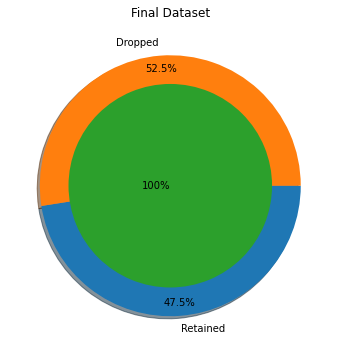


Inference: After the cleanup process, 9885 samples were dropped, while retaining 52.48% of the data.


In [13]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

## 4. Data Manipulation

In [14]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (8950, 26) (8950,) 
Training set  --->  (7160, 26) (7160,) 
Testing set   --->  (1790, 26)  (1790,)


In [15]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,tempo,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
count,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,...,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03,7.160000e+03
mean,-2.201839e-16,-9.368670e-17,-4.790860e-16,-1.105261e-16,2.271148e-16,-6.931141e-18,-1.079676e-16,-4.141008e-16,1.498336e-16,-1.500972e-16,...,2.755245e-16,-3.994710e-16,-2.493350e-16,-1.058573e-15,2.239828e-16,8.855889e-16,3.041174e-16,4.315294e-17,2.786102e-16,1.325910e-16
std,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,...,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00
min,-2.625387e+00,-9.181177e-01,-2.918774e+00,-3.131156e+00,-3.425841e-01,-1.575563e+00,-2.825473e+00,-1.348254e+00,-9.812680e-01,-2.528553e+00,...,-3.215677e-01,-1.695159e-01,-2.772249e-01,-3.073541e-01,-2.801351e-01,-3.603778e-01,-2.824479e-01,-3.239418e-01,-2.671612e-01,-2.974504e-01
25%,-6.702830e-01,-8.223387e-01,-6.452384e-01,-6.864460e-01,-3.425841e-01,-6.881147e-01,-5.876500e-01,-1.348254e+00,-6.975836e-01,-7.615380e-01,...,-3.215677e-01,-1.695159e-01,-2.772249e-01,-3.073541e-01,-2.801351e-01,-3.603778e-01,-2.824479e-01,-3.239418e-01,-2.671612e-01,-2.974504e-01
50%,-6.177447e-02,-4.150227e-01,5.798743e-02,1.271097e-01,-3.411082e-01,-3.751120e-01,1.864114e-01,7.417001e-01,-4.002151e-01,-1.426259e-02,...,-3.215677e-01,-1.695159e-01,-2.772249e-01,-3.073541e-01,-2.801351e-01,-3.603778e-01,-2.824479e-01,-3.239418e-01,-2.671612e-01,-2.974504e-01
75%,6.146981e-01,5.921024e-01,7.219555e-01,8.042306e-01,-2.673929e-01,4.767485e-01,7.447833e-01,7.417001e-01,2.966273e-01,6.418977e-01,...,-3.215677e-01,-1.695159e-01,-2.772249e-01,-3.073541e-01,-2.801351e-01,-3.603778e-01,-2.824479e-01,-3.239418e-01,-2.671612e-01,-2.974504e-01
max,2.716562e+00,2.672887e+00,2.386143e+00,1.703690e+00,6.650948e+00,2.864200e+00,2.376364e+00,7.417001e-01,3.368207e+00,2.773299e+00,...,3.109765e+00,5.899152e+00,3.607179e+00,3.253577e+00,3.569706e+00,2.774865e+00,3.540476e+00,3.086975e+00,3.743058e+00,3.361905e+00



                                          Standardardization on Testing set                                          


,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,tempo,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
count,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,...,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000
mean,0.036125,-0.014032,0.006938,0.028758,0.010602,-0.058353,0.026948,0.009632,-0.023773,-0.005688,...,-0.012939,0.006781,-0.001628,0.024867,-0.058608,-0.015326,0.025095,0.036205,-0.022964,-0.003066
std,0.971755,0.975985,0.990170,0.974326,1.002490,0.982153,0.979911,0.997307,0.968979,1.002542,...,0.981985,1.019502,0.997564,1.035975,0.896783,0.981478,1.040064,1.048494,0.959254,0.995564
min,-2.491247,-0.918115,-2.932429,-2.934083,-0.342584,-1.543058,-2.781757,-1.348254,-0.972847,-2.236695,...,-0.321568,-0.169516,-0.277225,-0.307354,-0.280135,-0.360378,-0.282448,-0.323942,-0.267161,-0.297450
25%,-0.613785,-0.815321,-0.624756,-0.610649,-0.342584,-0.734631,-0.562450,-1.348254,-0.703373,-0.755222,...,-0.321568,-0.169516,-0.277225,-0.307354,-0.280135,-0.360378,-0.282448,-0.323942,-0.267161,-0.297450
50%,-0.024516,-0.425960,0.064815,0.149849,-0.341076,-0.425551,0.223624,0.741700,-0.412847,-0.021330,...,-0.321568,-0.169516,-0.277225,-0.307354,-0.280135,-0.360378,-0.282448,-0.323942,-0.267161,-0.297450
75%,0.611647,0.586634,0.733904,0.809284,-0.262995,0.373068,0.727351,0.741700,0.323469,0.580851,...,-0.321568,-0.169516,-0.277225,-0.307354,-0.280135,-0.360378,-0.282448,-0.323942,-0.267161,-0.297450
max,2.685640,2.669241,2.345178,1.693583,6.608043,2.852991,2.786427,0.741700,3.368207,2.675691,...,3.109765,5.899152,3.607179,3.253577,3.569706,2.774865,3.540476,3.086975,3.743058,3.361905


## 5. Feature Selection/Extraction

                                       Correlation Matrix                                       


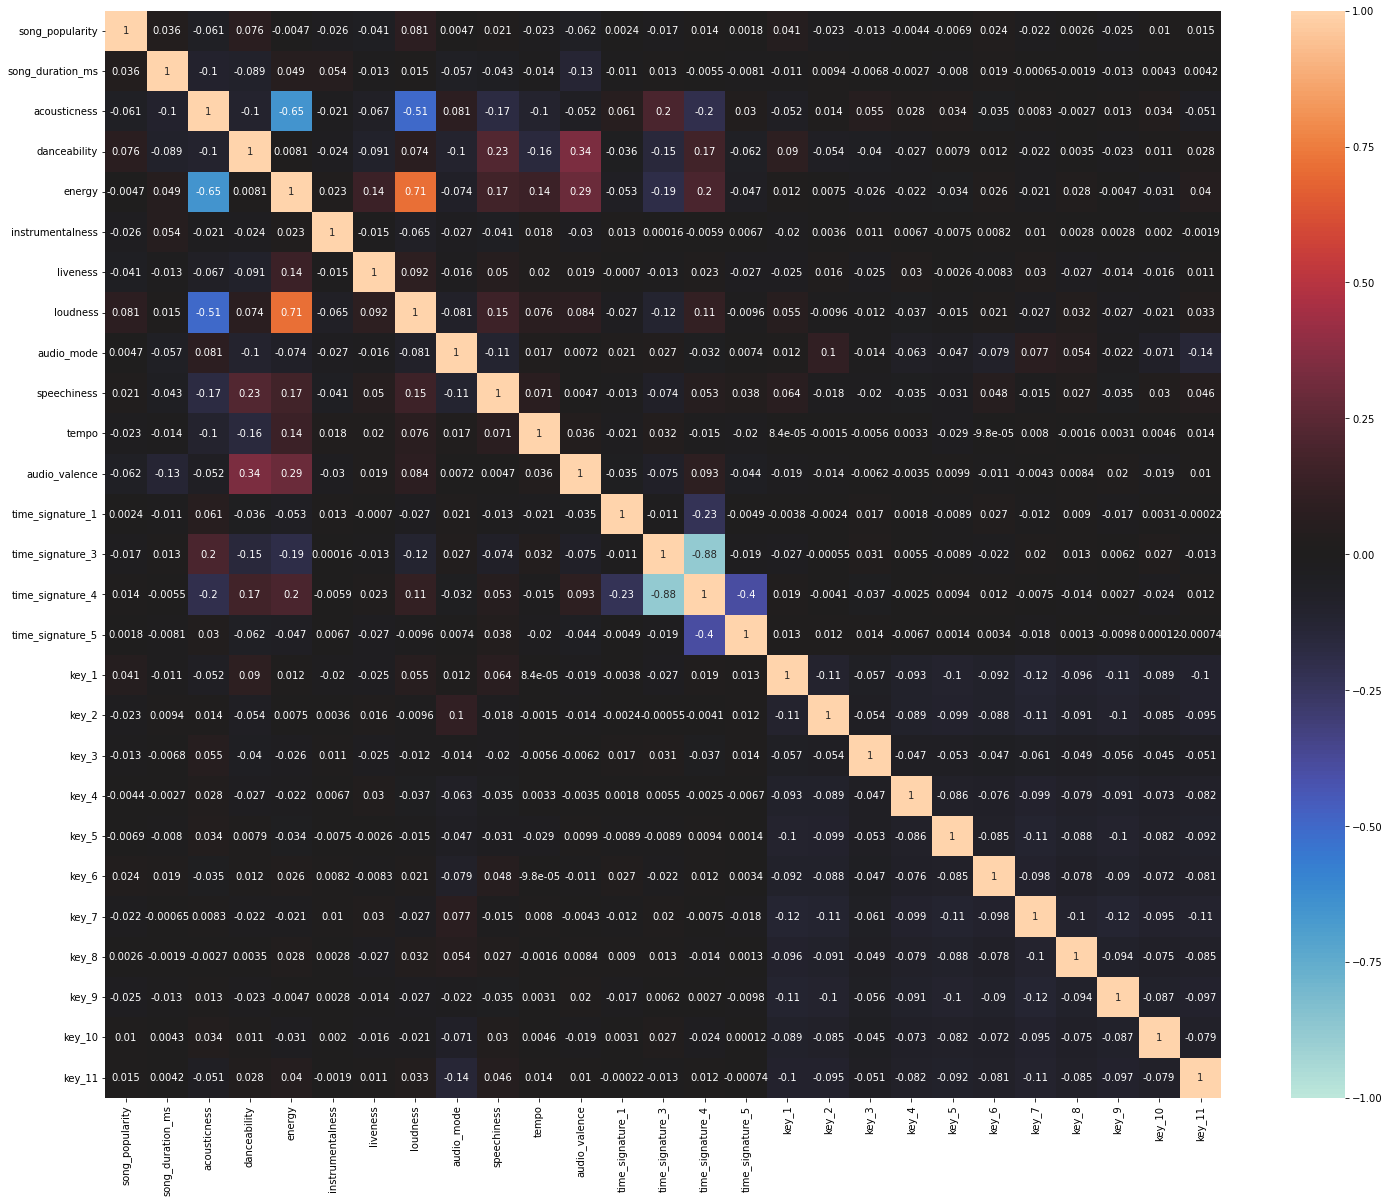

In [21]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

In [22]:
#Testing a Linear Regression model with statsmodels

Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
#print(API.conf_int())
#print(API.pvalues)
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        song_popularity   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     11.02
Date:                Sun, 17 Apr 2022   Prob (F-statistic):           4.09e-43
Time:                        02:51:11   Log-Likelihood:                -31711.
No. Observations:                7160   AIC:                         6.347e+04
Df Residuals:                    7134   BIC:                         6.365e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           50.2975      0.240    209.404      0.000      49.827      50.768
song_duration_ms     0.6780      0.246      2.760      0.006       0.196       1.160
acousticness        -1.6038      0.336     -4.771      0.000      -2.263      -0.945
danceability         1.7539      0.288      6.092      0.000       1.190       2.318
energy              -2.5832      0.450     -5.744      0.000      -3.465      -1.702
instrumentalness    -0.3207      0.243     -1.319      0.187      -0.797       0.156
liveness            -0.6221      0.245     -2.535      0.011      -1.103      -0.141
loudness             2.8740      0.358      8.038      0.000       2.173       3.575
audio_mode           0.4419      0.253      1.748      0.081      -0.054       0.938
speechiness         -0.3549      0.258     -1.374      0.170      -0.861       0.151
tempo               -0.1327      0.248     -0.534      0.593      -0.619       0.354
audio_valence       -1.4757      0.290     -5.086      0.000      -2.044      -0.907
time_signature_1     0.0417      0.235      0.177      0.859      -0.420       0.503
time_signature_3    -0.1411      0.160     -0.884      0.377      -0.454       0.172
time_signature_4     0.0944      0.126      0.746      0.455      -0.153       0.342
time_signature_5     0.0466      0.223      0.209      0.835      -0.391       0.484
key_1                0.4666      0.314      1.487      0.137      -0.148       1.082
key_2               -0.5856      0.308     -1.902      0.057      -1.189       0.018
key_3               -0.1645      0.265     -0.620      0.535      -0.685       0.356
key_4                0.1626      0.297      0.547      0.585      -0.421       0.746
key_5               -0.1874      0.306     -0.612      0.540      -0.787       0.413
key_6                0.2331      0.299      0.781      0.435      -0.352       0.818
key_7               -0.5738      0.319     -1.796      0.073      -1.200       0.053
key_8               -0.1306      0.297     -0.440      0.660      -0.713       0.451
key_9               -0.4823      0.310     -1.554      0.120      -1.091       0.126
key_10               0.2570      0.295      0.871      0.384      -0.321       0.835
key_11               0.3306      0.306      1.080      0.280      -0.269       0.930
==============================================================================
Omnibus:                      437.955   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              522.571
Skew:                          -0.661   Prob(JB):                    3.35e-114
Kurtosis:                       2.946   Cond. No.                     6.04e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matr

Dropped Features -->  ['time_signature_4', 'energy', 'key_7', 'acousticness', 'danceability', 'key_1', 'key_11', 'key_9', 'key_2', 'loudness', 'audio_mode', 'key_5', 'speechiness', 'audio_valence', 'key_4', 'key_6', 'key_3', 'key_8']


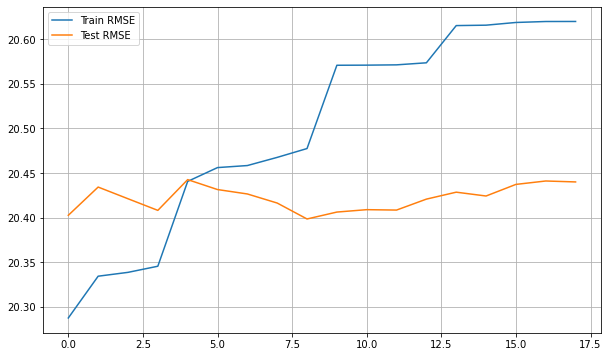

In [16]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
#Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
#Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

DROP=[];b=[]

for i in range(len(Train_X_std.columns)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

        #Trd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Train_Y, pred1)),2)
        #Tsd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),2)
        
print('Dropped Features --> ',DROP)
#plt.plot(b)
#plt.show()
#print(API.summary())

# plt.figure(figsize=[20,4])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

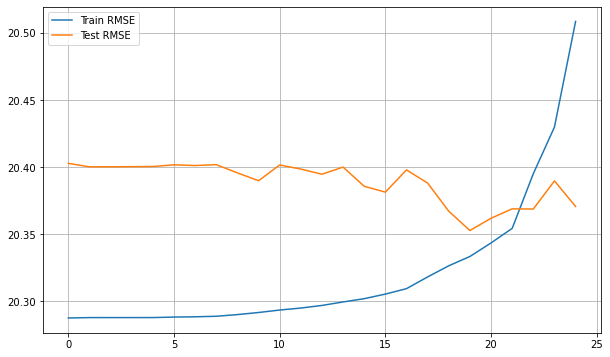

In [17]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m=df.shape[1]-2
for i in range(m):
    lm = LinearRegression()
    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)             # running RFE
    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

# plt.figure(figsize=[20,4])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

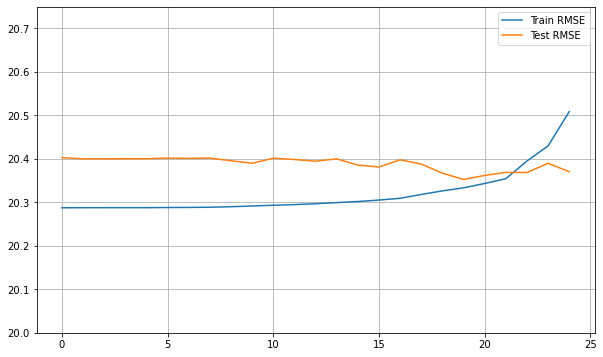

In [25]:
plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.ylim([20,20.75])
plt.legend()
plt.grid()
plt.show()

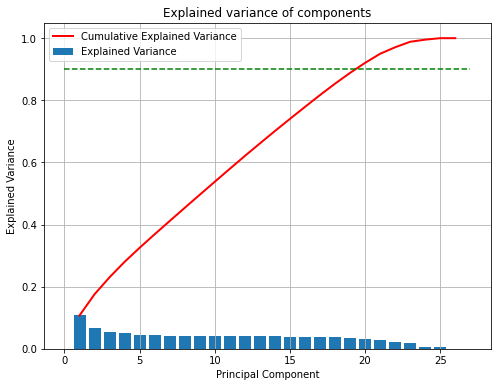

In [18]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

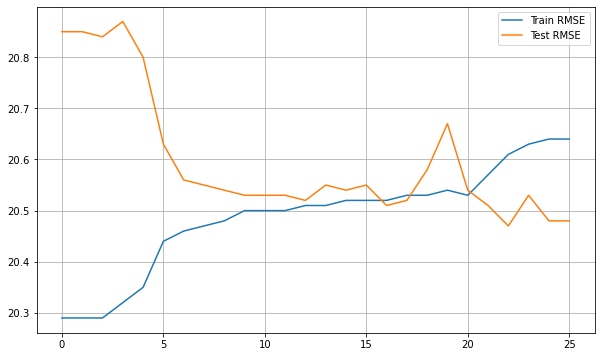

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-1

for i in range(m):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))

# plt.figure(figsize=[20,4.5])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.5,20.75])
plt.legend()
plt.grid()
plt.show()


In [20]:
# #Shortlisting the selected Features (with RFE)

lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-df.shape[1]+10)             # running RFE
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

#print(Train_X_std.loc[:,rfe.support_].columns)

pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

# Train_X_std = Train_X_std.loc[:,rfe.support_]
# Test_X_std = Test_X_std.loc[:,rfe.support_]

20.318048532828218
20.388036077109874


## 6. Predictive Modelling

In [21]:
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,3,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 6.78440238e-01 -1.59853551e+00  1.75490295e+00 -2.57674770e+00
 -3.28049722e-01 -6.17146678e-01  2.87170607e+00  4.43042135e-01
 -3.57475898e-01 -1.40969350e-01 -1.47691135e+00  9.40316939e+12
  3.42395837e+13  3.88302318e+13  1.66386403e+13  4.66258609e-01
 -5.86792715e-01 -1.64636931e-01  1.65945725e-01 -2.02122498e-01
  2.27285805e-01 -5.71712459e-01 -1.25864403e-01 -4.81618198e-01
  2.68902898e-01  3.28073006e-01]
The Intercept of the Regresion Model was found to be  50.28734552809424


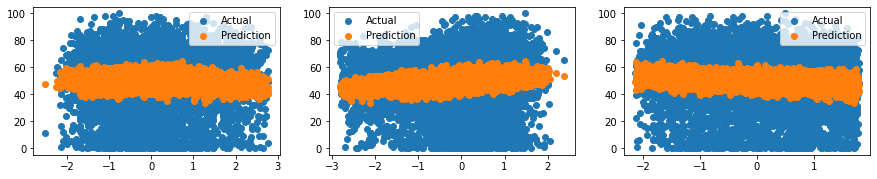



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.03719047615242743
Residual Sum of Squares (RSS) on Training set  ---> 2946915.7404336957
Mean Squared Error (MSE) on Training set       ---> 411.58041067509714
Root Mean Squared Error (RMSE) on Training set ---> 20.287444656119142

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.0034071823115348066
Residual Sum of Squares (RSS) on Training set  ---> 745124.0691605918
Mean Squared Error (MSE) on Training set       ---> 416.27042969865465
Root Mean Squared Error (RMSE) on Training set ---> 20.402706430732533

--------------------Residual Plots--------------------


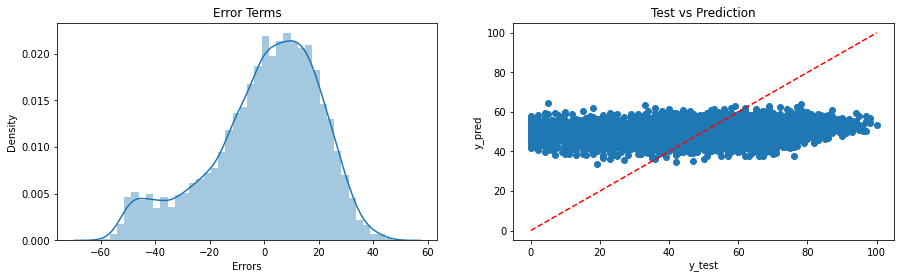

In [22]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 6.78440238e-01 -1.59853551e+00  1.75490295e+00 -2.57674770e+00
 -3.28049722e-01 -6.17146678e-01  2.87170607e+00  4.43042135e-01
 -3.57475898e-01 -1.40969350e-01 -1.47691135e+00  9.40316939e+12
  3.42395837e+13  3.88302318e+13  1.66386403e+13  4.66258609e-01
 -5.86792715e-01 -1.64636931e-01  1.65945725e-01 -2.02122498e-01
  2.27285805e-01 -5.71712459e-01 -1.25864403e-01 -4.81618198e-01
  2.68902898e-01  3.28073006e-01]
The Intercept of the Regresion Model was found to be  50.28734552809424


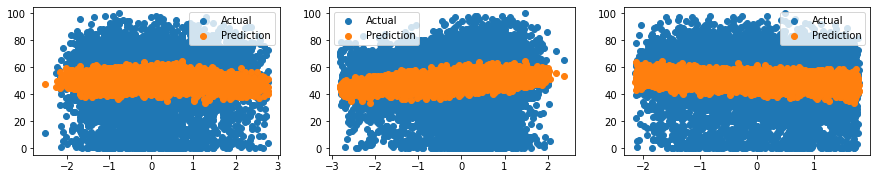



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.037189091772393934
Residual Sum of Squares (RSS) on Training set  ---> 2946919.977669837
Mean Squared Error (MSE) on Training set       ---> 411.5810024678543
Root Mean Squared Error (RMSE) on Training set ---> 20.28745924131098

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.003420710915271186
Residual Sum of Squares (RSS) on Training set  ---> 745113.954208841
Mean Squared Error (MSE) on Training set       ---> 416.2647788876206
Root Mean Squared Error (RMSE) on Training set ---> 20.40256794836426

--------------------Residual Plots--------------------


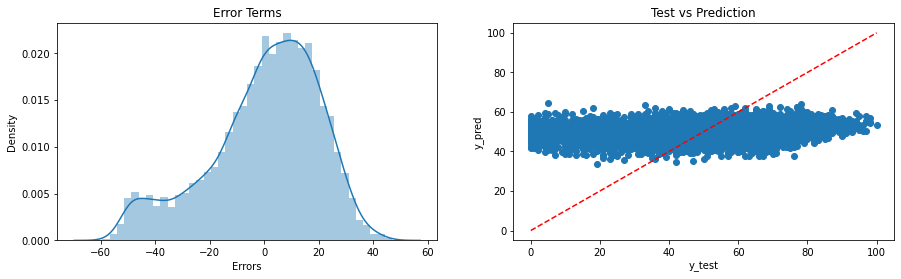

In [23]:
#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 6.78440238e-01 -1.59853551e+00  1.75490295e+00 -2.57674770e+00
 -3.28049722e-01 -6.17146678e-01  2.87170607e+00  4.43042135e-01
 -3.57475898e-01 -1.40969350e-01 -1.47691135e+00  9.40316939e+12
  3.42395837e+13  3.88302318e+13  1.66386403e+13  4.66258609e-01
 -5.86792715e-01 -1.64636931e-01  1.65945725e-01 -2.02122498e-01
  2.27285805e-01 -5.71712459e-01 -1.25864403e-01 -4.81618198e-01
  2.68902898e-01  3.28073006e-01]
The Intercept of the Regresion Model was found to be  50.28734552809424


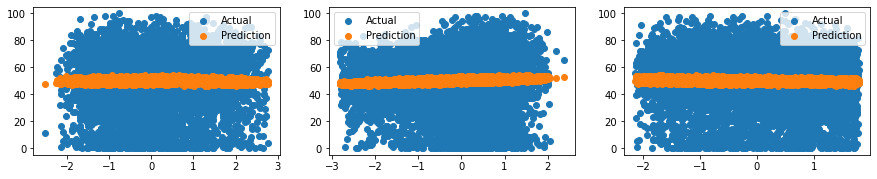



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.015140165780251126
Residual Sum of Squares (RSS) on Training set  ---> 3014406.14752641
Mean Squared Error (MSE) on Training set       ---> 421.00644518525286
Root Mean Squared Error (RMSE) on Training set ---> 20.51844158763654

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.007117147140071945
Residual Sum of Squares (RSS) on Training set  ---> 742350.234109388
Mean Squared Error (MSE) on Training set       ---> 414.72080117842904
Root Mean Squared Error (RMSE) on Training set ---> 20.364694968951266

--------------------Residual Plots--------------------


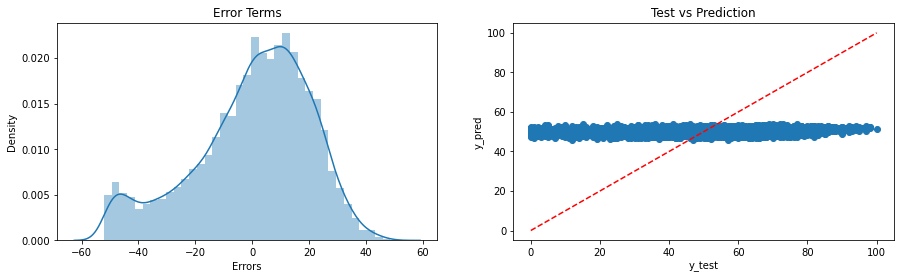

In [24]:
#Creating a Ridge Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 6.78440238e-01 -1.59853551e+00  1.75490295e+00 -2.57674770e+00
 -3.28049722e-01 -6.17146678e-01  2.87170607e+00  4.43042135e-01
 -3.57475898e-01 -1.40969350e-01 -1.47691135e+00  9.40316939e+12
  3.42395837e+13  3.88302318e+13  1.66386403e+13  4.66258609e-01
 -5.86792715e-01 -1.64636931e-01  1.65945725e-01 -2.02122498e-01
  2.27285805e-01 -5.71712459e-01 -1.25864403e-01 -4.81618198e-01
  2.68902898e-01  3.28073006e-01]
The Intercept of the Regresion Model was found to be  50.28734552809424


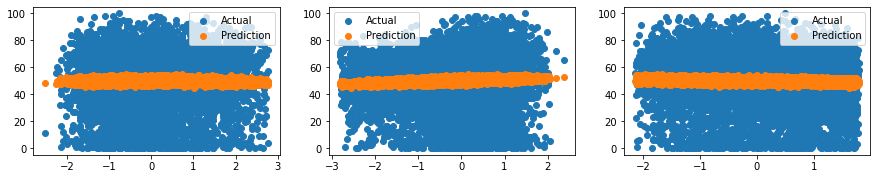



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.019205092299083293
Residual Sum of Squares (RSS) on Training set  ---> 3001964.438501573
Mean Squared Error (MSE) on Training set       ---> 419.26877632703537
Root Mean Squared Error (RMSE) on Training set ---> 20.476053729345296

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.007624464892474702
Residual Sum of Squares (RSS) on Training set  ---> 741970.9270731356
Mean Squared Error (MSE) on Training set       ---> 414.50889780622094
Root Mean Squared Error (RMSE) on Training set ---> 20.35949159007221

--------------------Residual Plots--------------------


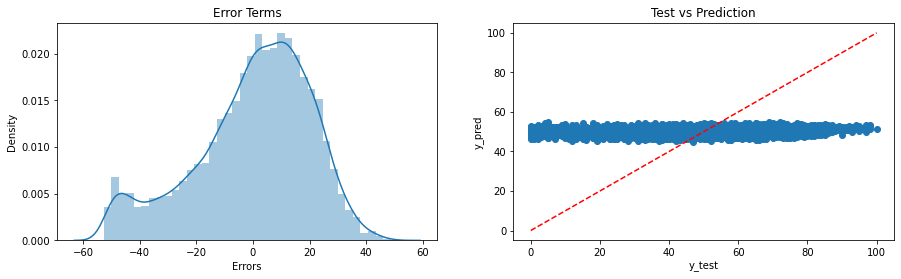

In [25]:
#Creating a ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

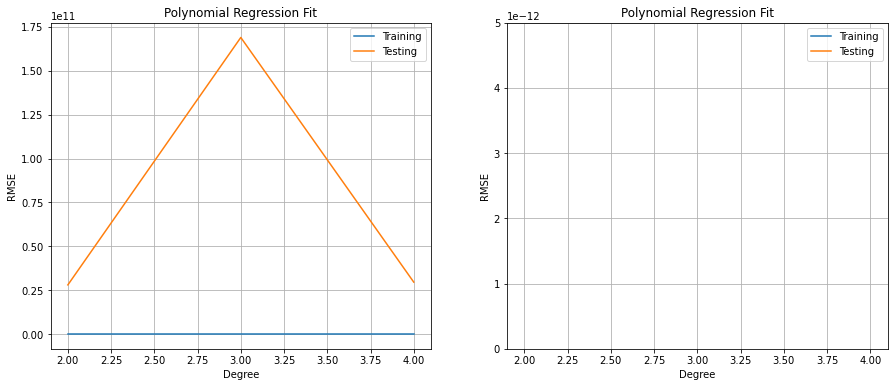

In [26]:
#Checking polynomial regression performance on various degrees

Trr=[]; Tss=[]
n_degree=5

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0,5e-12])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 6.78440238e-01 -1.59853551e+00  1.75490295e+00 -2.57674770e+00
 -3.28049722e-01 -6.17146678e-01  2.87170607e+00  4.43042135e-01
 -3.57475898e-01 -1.40969350e-01 -1.47691135e+00  9.40316939e+12
  3.42395837e+13  3.88302318e+13  1.66386403e+13  4.66258609e-01
 -5.86792715e-01 -1.64636931e-01  1.65945725e-01 -2.02122498e-01
  2.27285805e-01 -5.71712459e-01 -1.25864403e-01 -4.81618198e-01
  2.68902898e-01  3.28073006e-01]
The Intercept of the Regresion Model was found to be  50.28734552809424


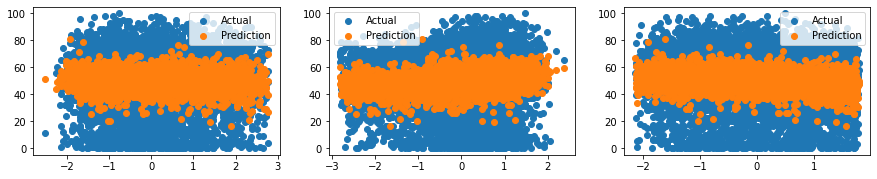



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.07763966892097307
Residual Sum of Squares (RSS) on Training set  ---> 2823111.021114846
Mean Squared Error (MSE) on Training set       ---> 394.2892487590567
Root Mean Squared Error (RMSE) on Training set ---> 19.85671797551289

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> -1.8739045396510979e+18
Residual Sum of Squares (RSS) on Training set  ---> 1.4010650598927075e+24
Mean Squared Error (MSE) on Training set       ---> 7.827179105545852e+20
Root Mean Squared Error (RMSE) on Training set ---> 27977096178.02722

--------------------Residual Plots--------------------


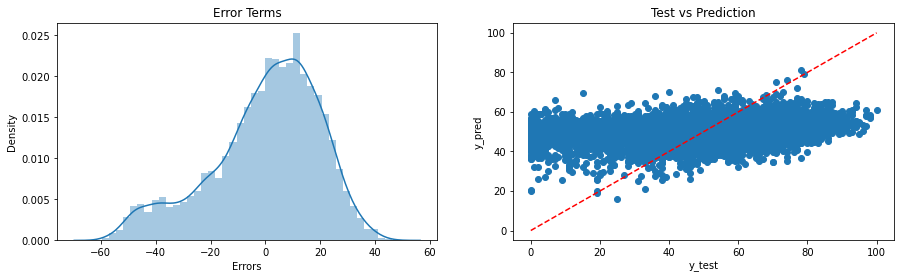

In [27]:
#Using the 2nd Order Polynomial Regression model (degree=2)

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

In [28]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.037190,3.407182e-03,2.946916e+06,7.451241e+05,411.580411,4.162704e+02,20.287445,2.040271e+01
Ridge Linear Regression (RLR),0.037189,3.420711e-03,2.946920e+06,7.451140e+05,411.581002,4.162648e+02,20.287459,2.040257e+01
Lasso Linear Regression (LLR),0.015140,7.117147e-03,3.014406e+06,7.423502e+05,421.006445,4.147208e+02,20.518442,2.036469e+01
Elastic-Net Regression (ENR),0.019205,7.624465e-03,3.001964e+06,7.419709e+05,419.268776,4.145089e+02,20.476054,2.035949e+01
Polynomial Regression (PNR),0.077640,-1.873905e+18,2.823111e+06,1.401065e+24,394.289249,7.827179e+20,19.856718,2.797710e+10


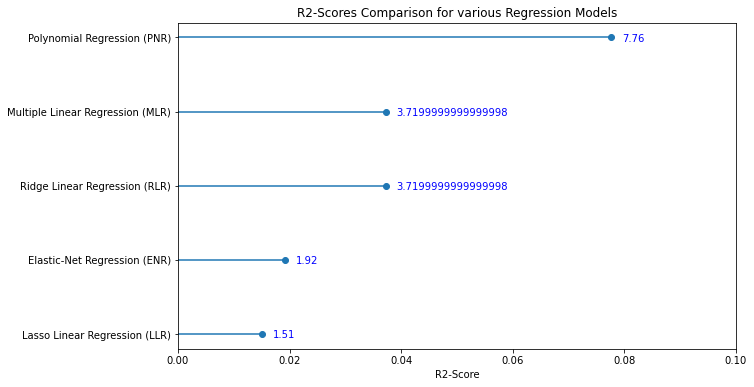

In [29]:
# R2-Scores Comparison for different Regression Models

R2 = round(EMC['Train-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.002, i-0.05, str(v*100), color='blue')
plt.xlim([0,0.1])
plt.show()

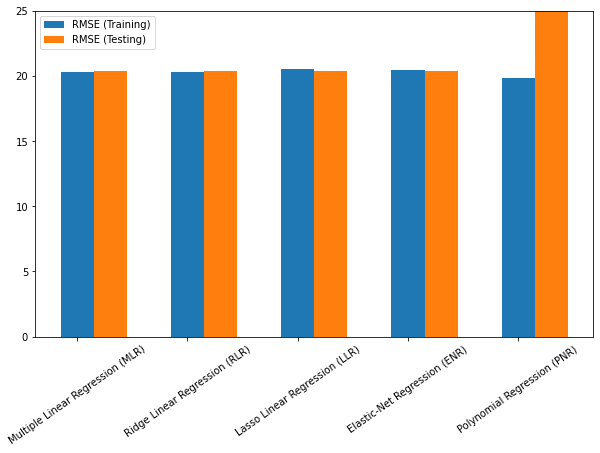

In [30]:
# Root Mean SquaredError Comparison for different Regression Models

cc = Model_Evaluation_Comparison_Matrix.columns.values
s=5
plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(5)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(5),EMC.index, rotation =35)
plt.legend()
plt.ylim([0,25])
plt.show()